In [1]:
import numpy as np
import os
import random
import torch 
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import segmentation_models_pytorch as smp

In [2]:
# this function guarantees reproductivity
def seed_everything(TORCH_SEED):
	random.seed(TORCH_SEED)
	os.environ['PYTHONHASHSEED'] = str(TORCH_SEED)
	np.random.seed(TORCH_SEED)
	torch.manual_seed(TORCH_SEED)
	torch.cuda.manual_seed_all(TORCH_SEED)
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False

In [3]:
seed = 1126
seed_everything(seed)

### Data Preprocessing

In [4]:
label_mapping = {
    0: 0,     
    1: 128,   
    2: 255    
}

In [5]:
def split_data(cases, size = [0.7, 0.1, 0.2]):
    np.random.shuffle(cases)

    total_size = len(cases)
    train_size = int(total_size * size[0])
    val_size = int(total_size * size[1])

    train_cases = cases[:train_size]
    val_cases = cases[train_size:train_size + val_size]
    test_cases= cases[train_size + val_size:]

    return train_cases, val_cases, test_cases

In [6]:
def get_image_training_transforms():
    """Training transforms for images only"""
    return transforms.Compose([
        transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
        transforms.RandomHorizontalFlip(p = 0.5),
        transforms.RandomVerticalFlip(p = 0.5),        
        # Normalization
        transforms.Normalize(mean = [0.5], std = [0.5])
    ])

def get_image_testing_transforms():
    """Testing/validation transforms for images only"""
    return transforms.Compose([
        transforms.Resize((256, 256), interpolation = transforms.InterpolationMode.NEAREST),
        transforms.Normalize(mean = [0.5], std = [0.5])
    ])

def get_label_transforms():
    """Transforms for labels - only resize with nearest neighbor"""
    return transforms.Compose([
        transforms.Resize((256, 256), interpolation = transforms.InterpolationMode.NEAREST),
    ])

In [7]:
class JointTransform:
    """Apply the same geometric transforms to both image and label"""
    
    def __init__(self, size = (256, 256), training = True):
        self.size = size
        self.training = training
    
    def __call__(self, image, label):
        # Resize both with appropriate interpolation
        image = TF.resize(image, self.size, interpolation = transforms.InterpolationMode.NEAREST)
        label = TF.resize(label, self.size, interpolation = transforms.InterpolationMode.NEAREST)
        
        if self.training:
            # Random horizontal flip
            if random.random() > 0.5:
                image = TF.hflip(image)
                label = TF.hflip(label)
            
            # Random vertical flip  
            if random.random() > 0.5:
                image = TF.vflip(image)
                label = TF.vflip(label)
        
        return image, label

class ImageOnlyTransform:
    """Apply transforms only to images (after joint transforms)"""    
    def __init__(self):
        self.transform = transforms.Normalize(mean = [0.5], std = [0.5])
    
    def __call__(self, image):
        return self.transform(image)

In [8]:
class LitsDataset(Dataset):
    def __init__(self, cases, training = True, use_joint_transforms = True):
        self.img_dir = './lits_dataset_preprocessed/'
        self.cases = cases
        self.training = training
        self.use_joint_transforms = use_joint_transforms
        self.data_pairs = []

        for case in cases:
            image_dir = os.path.join(self.img_dir, str(case), 'Image')
            label_dir = os.path.join(self.img_dir, str(case), 'GT')

            if not os.path.exists(image_dir) or not os.path.exists(label_dir):
                continue

            image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.npy')])
            
            for img_file in image_files:
                img_path = os.path.join(image_dir, img_file)
                label_path = os.path.join(label_dir, img_file)
                
                if os.path.exists(label_path):
                    self.data_pairs.append((img_path, label_path))
        
        # Setup transforms
        if use_joint_transforms:
            self.joint_transform = JointTransform(size = (256, 256), training = training)
            self.image_transform = ImageOnlyTransform()
            self.label_transform = None
        else:
            self.joint_transform = None
            self.image_transform = (get_image_training_transforms() if training 
                                  else get_image_testing_transforms())
            self.label_transform = get_label_transforms()

    def __len__(self):
        return len(self.data_pairs)
    
    def __getitem__(self, idx):
        img_path, label_path = self.data_pairs[idx]

        image = np.load(img_path)
        label = np.load(label_path)

        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).long()

        if image.ndim == 2:
            image = image.unsqueeze(0)
        
        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)  # Shape: [3, H, W]
        
        label = label.unsqueeze(dim = 0)

        # Apply transforms
        if self.use_joint_transforms and self.joint_transform:
            # Apply geometric transforms to both
            image, label = self.joint_transform(image, label)
            # Apply image-only transforms
            if self.image_transform:
                image = self.image_transform(image)
        else:
            # Apply separate transforms
            if self.image_transform:
                image = self.image_transform(image)
            if self.label_transform:
                label = self.label_transform(label)
        
        return image, label.squeeze(dim = 0)

In [9]:
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
cases = np.arange(131)

In [11]:
train_cases, val_cases, test_cases = split_data(cases)

In [12]:
print(train_cases.shape[0])
print(val_cases.shape[0])
print(test_cases.shape[0])

91
13
27


In [13]:
train_dataset = LitsDataset(train_cases, training = True, use_joint_transforms = True)
validation_dataset = LitsDataset(val_cases, training = False, use_joint_transforms = True)
testing_dataset = LitsDataset(test_cases, training = False, use_joint_transforms = False)

In [14]:
print(f'train size: {len(train_dataset)}')
print(f'valid size: {len(validation_dataset)}')
print(f'test size: {len(testing_dataset)}')

train size: 13352
valid size: 1502
test size: 4310


In [15]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
validation_loader = DataLoader(validation_dataset, batch_size = batch_size, shuffle = False)
testing_loader = DataLoader(testing_dataset, batch_size = batch_size, shuffle = False)

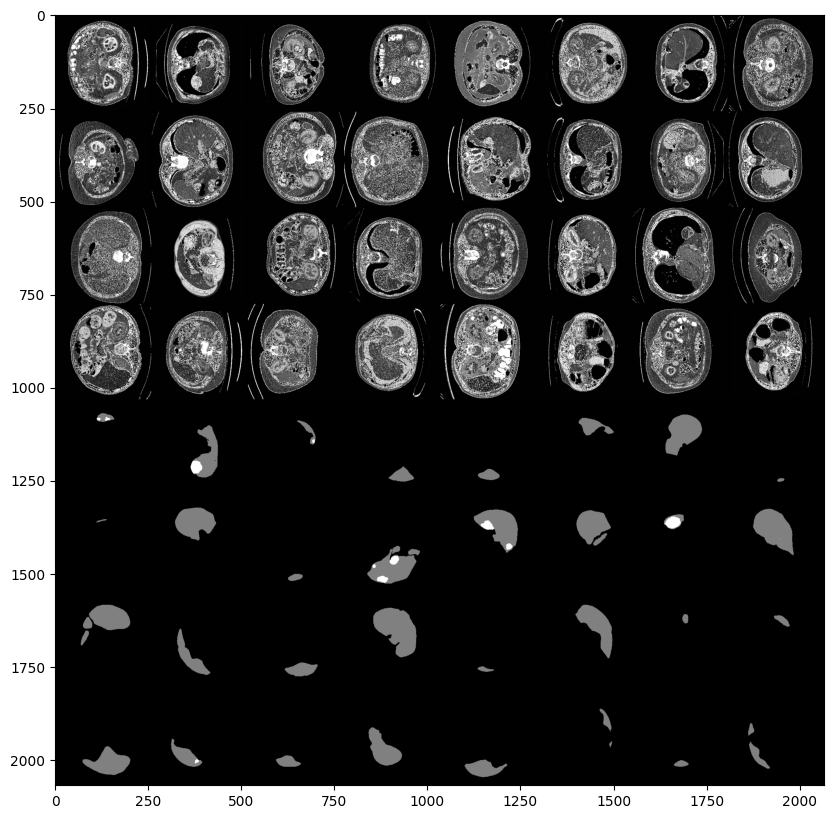

In [134]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
images = images * 255
images = images.to(torch.uint8)
labels = labels.apply_(label_mapping.get)
labels = torch.stack((labels, labels, labels), dim = 1)

grid_img = make_grid(images)
grid_label = make_grid(labels)
concat = torch.cat((grid_img, grid_label), dim = 1)

plt.figure(figsize = (10, 10))
plt.imshow(concat.permute(1, 2, 0))
plt.show()

### Model Training

In [16]:
class DiceLoss(nn.Module):
    def __init__(self, smooth = 1e-5, ignore_index = 0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.ignore_index = ignore_index  # classes to skip

    def forward(self, pred, target):
        num_classes = pred.shape[1]
        pred_softmax = F.softmax(pred, dim = 1)
        target_onehot = F.one_hot(target, num_classes).permute(0, 3, 1, 2).float()

        dice = []
        for c in range(num_classes):
            if c == self.ignore_index:
                continue  # skip background
            pred_c = pred_softmax[:, c]
            target_c = target_onehot[:, c]
            intersection = (pred_c * target_c).sum(dim = (1, 2))
            union = pred_c.sum(dim=(1, 2)) + target_c.sum(dim = (1, 2))
            dice_c = (2. * intersection + self.smooth) / (union + self.smooth)
            dice.append(dice_c)

        return 1. - torch.mean(torch.stack(dice))

In [17]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha = 0.5):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.ce = nn.CrossEntropyLoss()
        self.dice = DiceLoss()

    def forward(self, pred, target):
        return self.alpha * self.ce(pred, target) + (1 - self.alpha) * self.dice(pred, target)

In [ ]:
def calculate_metrics(preds, targets, n_classes=3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dice_scores = []
    iou_scores = []

    for cls in range(1, n_classes):  
        num = targets.shape[0]
        dice_sum = torch.tensor([0.0]).to(device)
        iou_sum = torch.tensor([0.0]).to(device)
        for i in range(0, num): 
            pred = preds[i]
            target = targets[i]
            pred_cls = (pred == cls)
            target_cls = (target == cls)

            intersection = torch.logical_and(pred_cls, target_cls).sum().float()
            union = torch.logical_or(pred_cls, target_cls).sum().float()

            if intersection + union > 0:
                dice = (2. * intersection) / (pred_cls.sum() + target_cls.sum() + 1e-6)
                iou = intersection / (union + 1e-6)
            else:
                dice = torch.tensor([1.0]).to(device)
                iou = torch.tensor([1.0]).to(device)
            dice_sum += dice
            iou_sum += iou
        dice_per = dice_sum / num
        iou_per = iou_sum / num

        dice_scores.append(dice_per.item())
        iou_scores.append(iou_per.item())

    return dice_scores, iou_scores

In [19]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, writer, num_epochs, patience = 10, save_dir = './model_storage/unet_plus_plus'):
    best_dice = 0.0 
    early_stop_count = 0

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Training
    for epoch in range(num_epochs):
        model.train()  
        running_loss = 0.0
        running_dice_1 = 0.0
        running_dice_2 = 0.0

        with tqdm(train_loader, desc = f'Epoch {epoch + 1}/{num_epochs}', unit = 'batch') as t:
            for inputs, labels in t:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                pred = torch.argmax(outputs, dim = 1)
                running_dices, _ = calculate_metrics(pred, labels)
                running_dice_1 += running_dices[0]
                running_dice_2 += running_dices[1]
                running_loss += loss.item()
                t.set_postfix(loss = running_loss / (t.n + 1), dice_1 = running_dice_1 / (t.n + 1), dice_2 = running_dice_2 / (t.n + 1))

        writer.add_scalar('Learning Rate', optimizer.param_groups[0]['lr'], epoch + 1)
        scheduler.step()

        epoch_loss = running_loss / len(train_loader)
        epoch_dice_1 = running_dice_1 / len(train_loader)
        epoch_dice_2 = running_dice_2 / len(train_loader)

        # Validation
        model.eval()  
        val_loss = 0.0
        val_dice_1 = 0.0
        val_dice_2 = 0.0
        with torch.no_grad(): 
            for inputs, labels in tqdm(val_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                pred = torch.argmax(outputs, dim = 1)
                val_dices,_ = calculate_metrics(pred, labels)
                val_dice_1 += val_dices[0]
                val_dice_2 += val_dices[1]
                val_loss += loss.item()

        val_loss = val_loss / len(val_loader)
        val_dice_1 = val_dice_1 / len(val_loader)
        val_dice_2 = val_dice_2 / len(val_loader)

        tqdm.write(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Dice1: {epoch_dice_1:.4f}, Train Dice2: {epoch_dice_2:.4f}')
        tqdm.write(f'Validation Loss: {val_loss:.4f}, Validation Dice1: {val_dice_1:.4f}, Validation Dice2: {val_dice_2:.4f}')

        writer.add_scalar('Loss/train', epoch_loss, epoch+1)
        writer.add_scalar('Dice_1/train', epoch_dice_1, epoch + 1)
        writer.add_scalar('Dice_2/train', epoch_dice_2, epoch + 1)

        writer.add_scalar('Loss/valid', val_loss, epoch+1)
        writer.add_scalar('Dice_1/valid', val_dice_1, epoch + 1)
        writer.add_scalar('Dice_2/valid', val_dice_2, epoch + 1)

        if val_dice_1 + val_dice_2 > best_dice:
            best_dice = val_dice_1 + val_dice_2
            torch.save(model.state_dict(), os.path.join(save_dir, 'best.pth'))
            tqdm.write(f"Best model saved with combined Dice {best_dice:.4f}")
            early_stop_count = 0
        else:
            early_stop_count += 1
        
        if early_stop_count >= patience:
            tqdm.write(f"Early Stop at {epoch + 1}!")
            break

In [20]:
def test_model(model, test_loader, criterion):
    model.eval()  
    test_dice_1 = []
    test_dice_2 = []
    test_iou_1 = []
    test_iou_2 = []
    test_loss = 0.0

    with torch.no_grad():  
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            preds = torch.argmax(outputs, dim = 1)
            test_dices, test_ious = calculate_metrics(preds, labels)
            test_dice_1.append(test_dices[0])
            test_dice_2.append(test_dices[1])
            test_iou_1.append(test_ious[0])
            test_iou_2.append(test_ious[1])

            loss = criterion(outputs, labels)
            test_loss += loss.item()

    test_loss = test_loss / len(test_loader)
    dice1 = sum(test_dice_1) / len(test_dice_1)
    dice2 = sum(test_dice_2) / len(test_dice_2)
    iou1 = sum(test_iou_1) / len(test_iou_1)
    iou2 = sum(test_iou_2) / len(test_iou_2)

    tqdm.write(f'Test Loss: {test_loss:.4f}, Dice1: {dice1:.4f}, Dice2: {dice2:.4f}, IoU1: {iou1:.4f}, IoU2: {iou2:.4f}')

    return test_dice_1, test_dice_2, test_iou_1, test_iou_2


In [21]:
def infernece(model, image):
    model.eval()  
    if image.ndim == 3:
        image = image.unsqueeze(dim = 0)
    
    with torch.no_grad():          
        image = image.to(device)
        output = model(image)
        pred = torch.argmax(output, dim = 1)

    return pred.cpu()

In [22]:
def display_result(image, pred, label):
    image = image * 255
    image = image.to(torch.uint8)
    image = image.permute(1, 2, 0)
    label = label.apply_(label_mapping.get)
    pred = pred.apply_(label_mapping.get)
    pred = pred.permute(1, 2, 0)

    plt.figure(figsize = (6, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(pred, cmap = 'gray')
    plt.title('Prediction')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(label, cmap = 'gray')
    plt.title('Ground Truth')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [23]:
encoder_name = 'resnet50'
encoder_weights = 'imagenet'
in_channels = 3
num_classes = 3
encoder_depth = 5

In [24]:
model = smp.UnetPlusPlus(encoder_name = encoder_name, encoder_weights = encoder_weights, in_channels = in_channels, classes = num_classes, encoder_depth = encoder_depth)
model = model.to(device)

In [25]:
LR = 0.01
num_epochs = 30

In [26]:
criterion = CombinedLoss()
optimizer = optim.Adam(model.parameters(), lr = LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.5)

In [27]:
writer = SummaryWriter('runs/unet_plus_plus')
writer.add_scalar('Loss/train', 10, 0)
writer.add_scalar('Dice_1/train', 0, 0)
writer.add_scalar('Dice_2/train', 0, 0)
writer.add_scalar('Loss/valid', 10, 0)
writer.add_scalar('Dice_1/valid', 0, 0)
writer.add_scalar('Dice_2/valid', 0, 0)

In [ ]:
train_model(model, train_loader, validation_loader, criterion, optimizer, scheduler, writer, num_epochs)

In [ ]:
checkpoint = './model_storage/unet_plus_plus/best.pth'
best_model = smp.UnetPlusPlus(encoder_name = encoder_name, encoder_weights = encoder_weights, in_channels = in_channels, classes = num_classes)
best_model.load_state_dict(checkpoint)
criterion = CombinedLoss()

In [ ]:
test_dice_1, test_dice_2, test_iou_1, test_iou_2 = test_model(best_model, testing_loader, criterion)

  0%|          | 0/135 [00:00<?, ?it/s]

Test Loss: 0.3808, Dice1: 0.1125, Dice2: 0.5947, IoU1: 0.0800, IoU2: 0.5947


In [ ]:
idx = random.randint(0, len(testing_dataset))
selected_img, selected_label = testing_dataset[idx]

In [ ]:
pred = infernece(best_model, selected_img)

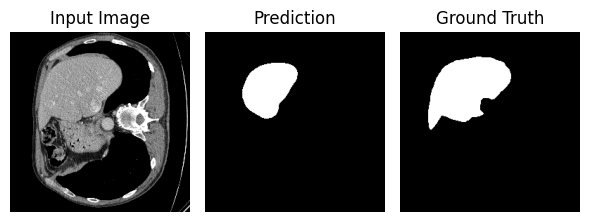

In [ ]:
display_result(selected_img, pred, selected_label)